In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Embedding
from keras.layers import Concatenate, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
import numpy as np
import torch
import torch.nn as nn                 # the torch module to implement the Neural Networks
import torch.nn.parallel              # for parallel computations
import torch.optim as optim           # for optimizers
import torch.utils.data               # tools
from torch.autograd import Variable   # for Stochastic Gradient Descent
import random as rnd

df = pd.read_csv('netflix_price.csv').astype({
    'movie_id' : 'int16',
    'user_id' : 'int32',
    'rating' : 'int8',
    'date' : 'datetime64[us]'
})

print(df)
df['user_id'] = df['user_id'].astype(np.uint32)
df['movie_id'] = df['movie_id'].astype(np.uint16)
df['rating'] = df['rating'].astype(np.uint8)

print(df.shape)


         Unnamed: 0  user_id  rating       date  movie_id
0                 0  1488844       3 2005-09-06         1
1                 1   822109       5 2005-05-13         1
2                 2   885013       4 2005-10-19         1
3                 3    30878       4 2005-12-26         1
4                 4   823519       3 2004-05-03         1
...             ...      ...     ...        ...       ...
5010194         755  1954284       5 2005-05-04      1000
5010195         756   299636       2 2005-10-27      1000
5010196         757  1635449       1 2005-01-10      1000
5010197         758   906984       4 2005-05-13      1000
5010198         759  2633357       3 2005-10-13      1000

[5010199 rows x 5 columns]
(5010199, 5)


In [2]:
df_movie_summary = df.groupby('movie_id')['rating'].agg(['count'])
sorted_movies = df_movie_summary.sort_values(by='count', ascending=False)
top_movies = sorted_movies.head(int(len(df_movie_summary) * .08))  # Select the top N movies by rating count
top_movies_ids = top_movies.index.tolist()  # Get the movie IDs of the top N movies
print(f'Number of Movies reduced to {(len(top_movies_ids) / len(df_movie_summary)) * 100}% from {len(df_movie_summary)} to {len(top_movies_ids)}')

df_customer_summary = df.groupby('user_id')['rating'].agg(['count'])
sorted_customers = df_customer_summary.sort_values(by='count', ascending=False)
top_customers = sorted_customers.head(int(len(df_customer_summary) * .08))  # Select the top N customers by rating count
top_customer_ids = top_customers.index.tolist()  # Get the movie IDs of the top N customers
print(f'Number of Customers reduced to {(len(top_customer_ids) / len(df_customer_summary))* 100}% from {len(df_customer_summary)} to {len(top_customer_ids)}')

print('Before Trim Shape: {}'.format(df.shape))

df = df[df['movie_id'].isin(top_movies_ids)]
df = df[df['user_id'].isin(top_customer_ids)]
print('After Trim Shape: {}'.format(df.shape))


Number of Movies reduced to 8.0% from 1000 to 80
Number of Customers reduced to 7.999901125928489% from 404555 to 32364
Before Trim Shape: (5010199, 5)
After Trim Shape: (1048460, 5)


In [3]:
num_movies = df['movie_id'].nunique()
num_users = df['user_id'].nunique()

unique_users = df['user_id'].unique()
unique_movies = df['movie_id'].unique()
unique_users.sort()
unique_users.sort()

print("Users: ", num_users)
print("Movies :",num_movies)

x = df[['user_id','rating', 'movie_id']].values
y = df['rating'].values
print(df)
x_training, x_test, y_training, y_test = train_test_split(x, y, test_size=0.2)
# x_train, x_val, y_train, y_val = train_test_split(x_training, y_training, test_size=0.1)

# convert to a users x movies matrix
def transform(data):
    new_data = []
    for cust_id in unique_users:
        # get all movies from this user
        movie_ids = data[:,2][data[:,0]==cust_id]
        # get all ratings from this user
        rating_ids = data[:,1][data[:,0]==cust_id]
        ratings = np.zeros(num_movies)
        # fill in the user's row with the ratings
        for movie_id in movie_ids :
          idx_in_rating_list =  list(unique_movies).index(movie_id)
          ratings[idx_in_rating_list] = rating_ids[list(movie_ids).index(movie_id)]
        new_data.append(list(ratings))

    return new_data

x_training_df_before_transform = x_training

x_training = np.array(x_training)
x_test = np.array(x_test)
x_training = transform(x_training)
x_test_matrix = transform(x_test)

Users:  32364
Movies : 80
         Unnamed: 0  user_id  rating       date  movie_id
5111             13  1744889       1 2005-08-25         8
5114             16  2289614       3 2005-03-20         8
5121             23  1395430       2 2005-03-22         8
5136             38    66358       3 2005-04-20         8
5146             48  1205593       4 2005-05-09         8
...             ...      ...     ...        ...       ...
4969430       18272   910676       2 2005-04-22       989
4969436       18278  1898433       5 2005-05-16       989
4969451       18293  2407365       4 2005-07-01       989
4969452       18294  1396502       4 2005-07-02       989
4969453       18295   477466       2 2005-09-23       989

[1048460 rows x 5 columns]


RMSE:  1.2257179323048433


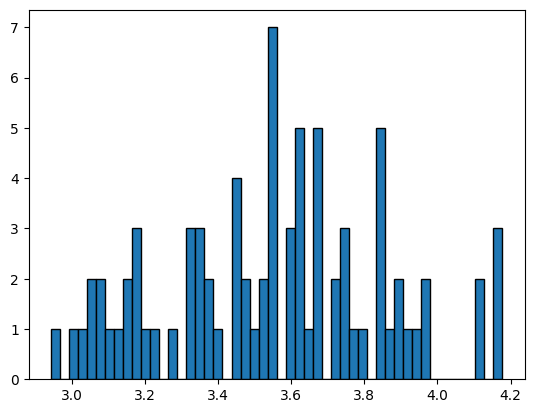

In [4]:
averages = {}
for movie in unique_movies:
    averages[movie] = df[df['movie_id'] == movie]['rating'].mean()

plt.hist(averages.values(), bins=50, edgecolor='black')   

from scipy import stats

def percentile_to_rating(percentile):
    rating = 0
    if(percentile < .05):
        rating = 1
    elif(percentile < .10):
        rating = 2
    elif(percentile < .43):
        rating = 3
    elif(percentile < .78):
        rating = 4
    else:
        rating = 5
    return rating    

average_score_results = []
for row in x_test:
   average = averages[row[2]]
   percentile = stats.percentileofscore(list(averages.values()), average) 
   average_score_results.append(percentile_to_rating(percentile/100))

MSE = mean_squared_error(y_test, average_score_results)
print("RMSE: ", pow(MSE,1/2))

0.8418974876403809 2
epoch: 1 loss: 0.42094874382019043
0.37553614377975464 2
epoch: 2 loss: 0.18776807188987732
0.5174422711133957 2
epoch: 3 loss: 0.25872113555669785
[[ 135348       3      30]
 [2449717       4     312]
 [2418634       3     118]
 ...
 [ 508852       3     357]
 [ 704066       4     443]
 [ 287901       2      28]]
[[ 135348       3      30]
 [2449717       4     312]
 [2418634       3     118]
 ...
 [ 508852       3     357]
 [ 704066       4     443]
 [ 287901       2      28]]


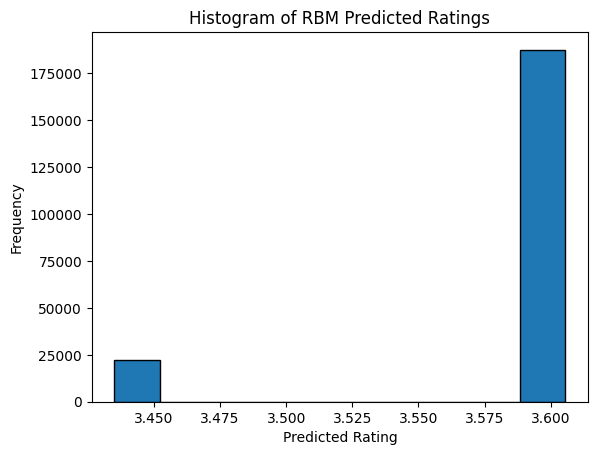

RMSE:  1.0273572488018692


In [5]:
x_training_tensor = torch.FloatTensor(x_training)
x_test_tensor = torch.FloatTensor(x_test_matrix)

# x_training = x_training / 5.0
# x_test_tensor = x_test_tensor / 5.0
x_test_tensor[x_test_tensor == 0] = -1
x_test_tensor[x_test_tensor == 1] = 0
x_test_tensor[x_test_tensor == 2] = 0
x_test_tensor[x_test_tensor > 2] = 1

x_training_tensor[x_training_tensor == 0] = -1
x_training_tensor[x_training_tensor == 1] = 0
x_training_tensor[x_training_tensor == 2] = 0
x_training_tensor[x_training_tensor > 2] = 1



class RBM():
    def __init__(self, visible_nodes, hidden_nodes):
        self.Weights = torch.randn(hidden_nodes, visible_nodes)
        self.bias = torch.randn(1, hidden_nodes)
        self.bias2 = torch.randn(1, visible_nodes)
        
    def sample_hidden_nodes(self, visible_neurons):
        wx = torch.mm(visible_neurons, self.Weights.t())
        activation = wx + self.bias.expand_as(wx)
        p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v, torch.bernoulli(p_h_given_v)
    
    def sample_visible_nodes(self, y):
        wy = torch.mm(y, self.Weights)
        activation = wy + self.bias2.expand_as(wy)
        p_v_given_h = torch.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)
    
    def train(self, input_ratings_vector, visible_nodes_k_samples, probability_vector, prob_hidden_nodes_k_samples):
        self.Weights += (torch.mm(input_ratings_vector.t(), probability_vector) - 
                   torch.mm(visible_nodes_k_samples.t(), prob_hidden_nodes_k_samples)).t()
        self.bias2 += torch.sum((input_ratings_vector-visible_nodes_k_samples), 0)
        self.bias += torch.sum((probability_vector-prob_hidden_nodes_k_samples), 0)



visible_nodes = len(x_training_tensor[0])      # no. of visible nodes
hidden_nodes = 300                    # the features to be detected by RBM, hence can define any relevant number
batch_size = 300
rbm = RBM(visible_nodes, hidden_nodes)
optimizer = torch.optim.Adam([rbm.Weights, rbm.bias, rbm.bias2], lr=0.001)
num_epoch = 3        # 10 because as we have a binary outcome and less data, the model will converge quickly


import torch.nn as nn

# Define the loss function
loss_function = nn.MSELoss()

# creating a for loop to iterate through these epochs and in each epoch all observations go in the network 
# and then updating the weights after observations of each batch that passed through the network
# and then we get our final visible nodes with new ratings for the movies that were not orignally rated
for epoch in range(1, num_epoch+1):
    train_loss = 0                      
    s = 0                          
    
    for user_number in range(0, num_users - batch_size, batch_size):
        id_user = unique_users[user_number]
        id_end_user = unique_users[user_number + batch_size]
        # CHECK THIS; LIKELY WRONG
        # should unique_users be sorted?
        visible_node = x_training_tensor[id_user:id_end_user]
        movie_vector = x_training_tensor[id_user:id_end_user]
        probability_hidden_node,_ = rbm.sample_hidden_nodes(movie_vector)
        
        for gibbs_samples in range(10):
            _,hidden_nodes_at_k = rbm.sample_hidden_nodes(visible_node)
            _,visible_node = rbm.sample_visible_nodes(hidden_nodes_at_k)
            visible_node[movie_vector<0] = movie_vector[movie_vector<0] 
    
        phk,_ = rbm.sample_hidden_nodes(visible_node)
        rbm.train(movie_vector, visible_node, probability_hidden_node, phk)
        
        # Zero the gradients before backward pass and optimization step
        optimizer.zero_grad()

        
        loss = loss_function(movie_vector[movie_vector >= 0], visible_node[movie_vector >= 0])
        if(not loss.isnan()):
            train_loss+=loss.item()
            s += 1

        # Update weights
        optimizer.step()
    print(train_loss, s)
    if(s > 0):
        print('epoch: ' + str(epoch) + ' loss: ' + str(train_loss/s) )

def get_test_results_from_matrix(test, results) :
    test_results = []
    print(test)
    for entry in test:
        user_id = entry[0]
        movie_id = entry[2]
        user_idx = list(unique_users).index(user_id)
        movie_idx = list(unique_movies).index(movie_id)
        prediction = results[user_idx][movie_idx]
        test_results.append(prediction)
    return test_results

def predict(rbm_model, input_data):
    _, hidden_nodes = rbm_model.sample_hidden_nodes(input_data)
    probabilities, visible_nodes = rbm_model.sample_visible_nodes(hidden_nodes)
    return probabilities, visible_nodes

def map_probabilities(probabilities):
    final_predictions = []
    final_probabilities = []
    for user_row in probabilities :
        user_predictions = np.zeros(len(user_row))
        user_probs = np.zeros(len(user_row))
        for i, user_rating in enumerate(user_row) :
            prediction = 0
            if user_rating < 0.03 :
                prediction = 1
            elif user_rating < 0.25 :
                prediction = 2
            elif user_rating < 0.44 :
                prediction = 3
            elif user_rating < 0.98 :
                prediction = 5
            else :
                prediction = 4
            user_predictions[i] = prediction
            user_probs[i] = user_rating
        final_predictions.append(user_predictions)
        final_probabilities.append(user_probs)
    return final_predictions, final_probabilities

probabilities, results = predict(rbm, x_test_tensor)
new_results, final_probs = map_probabilities(probabilities)

rbm_predictions = get_test_results_from_matrix(x_test, new_results)
rbm_probabilities = get_test_results_from_matrix(x_test, final_probs)

from sklearn.linear_model import LinearRegression
rbm_X = np.array(rbm_probabilities).reshape(-1, 1)
rbm_y = np.array(y_test).reshape(-1, 1)
rbm_model = LinearRegression()
rbm_model.fit(rbm_X, rbm_y)

# Make predictions on the test set
rbm_predictions2 = rbm_model.predict(rbm_X)

MSE = mean_squared_error(y_test, rbm_predictions2)

plt.hist(rbm_predictions2, bins=10, edgecolor='black')
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.title('Histogram of RBM Predicted Ratings')
plt.show()

print("RMSE: ", pow(MSE,1/2))



[[5. 0. 5. ... 5. 0. 5.]
 [0. 0. 3. ... 0. 4. 0.]
 [0. 0. 5. ... 0. 0. 0.]
 ...
 [0. 0. 5. ... 0. 1. 0.]
 [0. 0. 3. ... 0. 4. 0.]
 [0. 4. 3. ... 0. 4. 0.]]


C:\Users\13bpr\AppData\Local\Temp\ipykernel_2392\2457659358.py:10: RuntimeWarning: Mean of empty slice
  user_means = np.nanmean(x_training_array, axis=1)


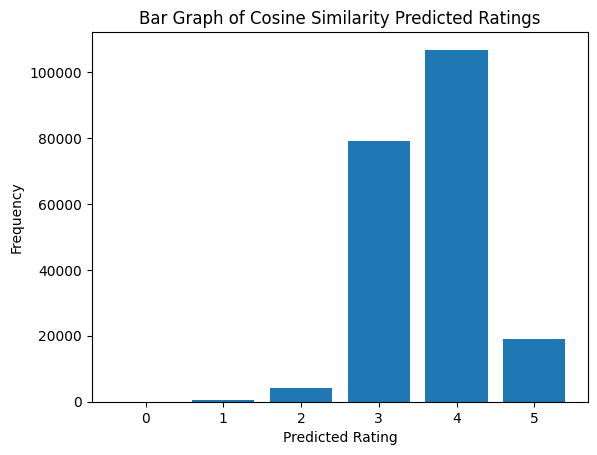

RMSE:  1.0818976158649032


In [6]:
# For each user, get it's neighbors using cosine similarity
from scipy.spatial.distance import cosine
from scipy import stats

x_training_array = np.array(x_training, dtype=float)
print(x_training_array)
x_training_array[x_training_array == 0] = np.nan

# Calculate mean of each user's ratings, excluding NaN values
user_means = np.nanmean(x_training_array, axis=1)

# # Zero-center the user vectors, replacing NaN with 0
zero_centered_users = np.nan_to_num(x_training_array - user_means.reshape(-1, 1), nan=0)

# Fit the NearestNeighbors model
from sklearn.neighbors import NearestNeighbors
nn_model = NearestNeighbors(metric='cosine')
nn_model.fit(zero_centered_users)

# Get indices and distances of neighbors
distances, indices = nn_model.kneighbors(zero_centered_users, n_neighbors=50)

import numpy as np
cosine_mode_predictions = []
for row in x_test:
    userId = row[0]
    movie_id = row[2]
    index = list(unique_users).index(userId)
    user = x_training[index]
    similar_indices = indices[index]
    movie_ratings = []
    for value in similar_indices:
        similar_user_ratings = x_training[value]
        rating = similar_user_ratings[list(unique_movies).index(movie_id)]
        if(rating > 0):
            movie_ratings.append(rating)
    if(len(movie_ratings) == 0):
        cosine_mode_predictions.append(4)
    else:
        cosine_mode_predictions.append(stats.mode(movie_ratings).mode)

MSE = mean_squared_error(y_test, cosine_mode_predictions)
cosine_counts = np.bincount(cosine_mode_predictions)
cosine_ratings = np.arange(len(cosine_counts))
plt.bar(cosine_ratings, cosine_counts)
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.title('Bar Graph of Cosine Similarity Predicted Ratings')
plt.show()
print("RMSE: ", pow(MSE,1/2))

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ANOVA for Cluster 0 (Training Set):
F-statistic: 6.774192761182016, p-value: 0.009248692452357297

ANOVA for Cluster 1 (Training Set):
F-statistic: 6.804527164556923, p-value: 0.009092862810444012

ANOVA for Cluster 2 (Training Set):
F-statistic: 9.459979540490401, p-value: 0.0021001010936567486

ANOVA for Cluster 3 (Training Set):
F-statistic: 5.792287638579821, p-value: 0.016096841668008906

ANOVA for Cluster 4 (Training Set):
F-statistic: 1.3785612803913865, p-value: 0.24034669567981218

ANOVA for Cluster 5 (Training Set):
F-statistic: 1.2434328625304336, p-value: 0.2648107976220219

ANOVA for Cluster 6 (Training Set):
F-statistic: 3.9981370305178157, p-value: 0.04555090400203935

ANOVA for Cluster 7 (Training Set):
F-statistic: 0.5693173022114062, p-value: 0.4505305397941288

ANOVA for Cluster 8 (Training Set):
F-statistic: 0.6801642920428354, p-value: 0.40953038924092133

ANOVA for Cluster 9 (Training Set):
F-statistic: 2.907300183349886, p-value: 0.08817974153960655

ANOVA for Cl

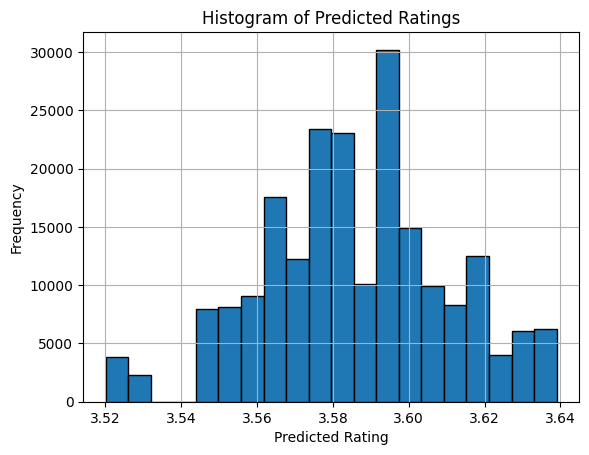

In [7]:
from sklearn.cluster import KMeans
from scipy.stats import f_oneway

cluster_train_data = pd.DataFrame(x_training_df_before_transform, columns = ['user_id', 'rating', 'movie_id'])

cluster_test_data = pd.DataFrame(x_test, columns = ['user_id', 'rating', 'movie_id'])

# Convert the ratings matrix to a NumPy array
train_ratings_matrix_array = x_training

# Apply k-means clustering on the training set
num_clusters = 100  # Adjust the number of clusters based on your needs
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_train_data['cluster'] = kmeans.fit_predict(cluster_train_data[['user_id', 'rating', 'movie_id']])

# Perform ANOVA on the training set clusters
most_significant_cluster = None
min_p_value = float('inf')  # Initialize with a large value

for cluster in range(num_clusters):
    cluster_ratings = cluster_train_data[cluster_train_data['cluster'] == cluster]['rating']
    
    # Check if there are at least two unique ratings within the cluster
    if len(cluster_ratings.unique()) > 1:
        print(f"ANOVA for Cluster {cluster} (Training Set):")
        f_statistic, p_value = f_oneway(cluster_ratings, cluster_train_data['rating'])
        print(f"F-statistic: {f_statistic}, p-value: {p_value}")
        
        # Update the most significant cluster if needed
        if p_value < min_p_value:
            min_p_value = p_value
            most_significant_cluster = cluster
        
        print()
    else:
        print(f"Insufficient data for ANOVA in Cluster {cluster} (Training Set)")

# Print the most significant cluster
print(f"The most significant cluster is Cluster {most_significant_cluster} with p-value {min_p_value}")

cluster_test_data['cluster'] = kmeans.predict(cluster_test_data[['user_id', 'rating', 'movie_id']])

# Merge test_data with the cluster means from the training set
test_data_with_means = cluster_test_data.merge(cluster_train_data.groupby('cluster')['rating'].mean().reset_index(), on='cluster', how='left')
test_data_with_means.rename(columns={'rating_x': 'actual_rating', 'rating_y': 'predicted_rating'}, inplace=True)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data_with_means['actual_rating'], test_data_with_means['predicted_rating']))
anova_predictions = list(test_data_with_means['predicted_rating'])
print(f"Root Mean Squared Error (RMSE): {rmse}")

test_data_with_means['predicted_rating'].hist(bins=20, edgecolor='black')
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Ratings')
plt.show()


Predicted rating for user  on movie 10: 2.0673943508576476


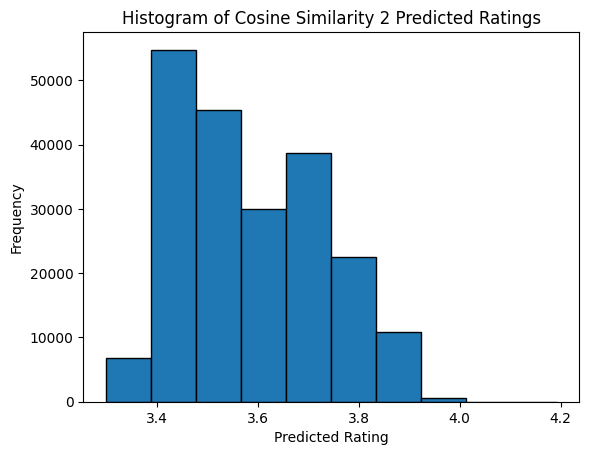

Root Mean Squared Error (RMSE): 1.0091700290808765


In [8]:
# Calculating cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

user_similarity = cosine_similarity(x_training, dense_output=False)

x_training_df = pd.DataFrame(x_training)

def predict_ratings(user_id, movie_id):
    user_row = x_training_df.iloc[:,movie_id]
    sim_scores = user_similarity[user_id]
    # movie_ratings = movie_feat.loc['movie_id']==movie_id]

    # Calculate the weighted sum of ratings
    if(sim_scores.sum() == 0):
        return 4
    prediction = user_row.dot(sim_scores) / sim_scores.sum()
    return prediction

# Example: Predicting rating for user_id=10, movie_id=10
predicted_rating = predict_ratings(100, 10)

print(f"Predicted rating for user  on movie 10: {predicted_rating}")

cosine_predictions_2 = []
original_ratings = []

for row in x_test:
  user_id = row[0]
  movie_id = row[2]
  user_id_loc = list(unique_users).index(user_id)
  movie_id_loc = list(unique_movies).index(movie_id)
  prediction = predict_ratings(user_id_loc, movie_id_loc)
  cosine_predictions_2.append(prediction)
  original_ratings.append(row[1])

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
cosine_X = np.array(cosine_predictions_2).reshape(-1, 1)
cosine_y = np.array(original_ratings).reshape(-1, 1)
model = LinearRegression()
model.fit(cosine_X, cosine_y)

# Make predictions on the cosine predictions
cosine_average_predictions = model.predict(cosine_X)

plt.hist(cosine_average_predictions, bins=10, edgecolor='black')
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Similarity 2 Predicted Ratings')
plt.show()

mse = mean_squared_error(cosine_average_predictions, original_ratings, squared=False)
print(f"Root Mean Squared Error (RMSE): {mse**0.5}")

Amount of Predictions: 209692


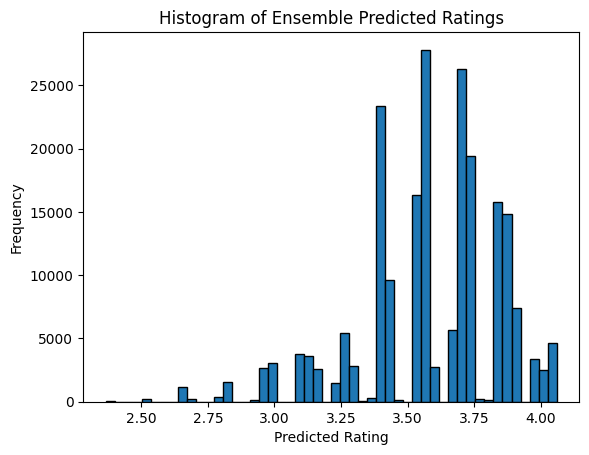

Final RMSE:  0.9936546534864389


In [9]:
ensemble_predictions = []
averages = []
print("Amount of Predictions:", len(rbm_predictions))
for i, rating in enumerate(rbm_predictions):
    ratings = []
    ratings.append(rating)
    ratings.append(cosine_mode_predictions[i])
    ratings.append(average_score_results[i])
    ratings.append(anova_predictions[i])
    ratings.append(cosine_average_predictions[i])
    average = sum(ratings) / len(ratings)
    averages.append(average)


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression
X = np.array(averages).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y_test)

# Make predictions on the test set
ensemble_predictions = model.predict(X)

import matplotlib.pyplot as plt
plt.hist(ensemble_predictions, bins=50, edgecolor='black')
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Ensemble Predicted Ratings')
plt.show()

MSE = mean_squared_error(y_test, ensemble_predictions)
print("Final RMSE: ", pow(MSE,1/2))    

# 5 mins on 96%
# 11 mins on 94%
# 36 mins on 92%
# 42 mins on 91%
# 1h 40m on 93% users 50% movies